In [1]:
import os
import traceback
import pandas as pd
pd.set_option('display.max_columns', None)
from typing import Tuple, Dict, List

from langchain_huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import marshal


from pinecone import Pinecone, ServerlessSpec
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

In [3]:
data_path = "/Users/wenyuanchen/Library/CloudStorage/Box-Box/ART_PerMessage_1_17_Updated.xlsx"
data_sample = pd.read_excel(data_path, nrows=100)  # or whatever number of rows you want

In [5]:
data_sample["Message Position in Thread"].unique()

array([1])

In [25]:
# Find Thread_IDs that appear once now
thread_counts = data_sample['Thread ID'].value_counts()
threads_to_keep = thread_counts[thread_counts == 1].index

# Filter the dataframe to keep only rows with those Thread_IDs
filtered_data = data_sample[data_sample['Thread ID'].isin(threads_to_keep)].sort_values('Thread ID')


In [26]:
# Filter out rows where patient message and actual response are not present
condition =(filtered_data["Patient Message"].notna()) & (filtered_data["Actual Response Sent to Patient"].notna())
filtered_data = filtered_data[condition]
filtered_data["Thread ID"].nunique() # only 2674 threads left


2674

In [27]:
question_answer_pairs = filtered_data[["Thread ID","Patient Message", "Actual Response Sent to Patient"]]

In [8]:
question_answer_pairs["_id"] = question_answer_pairs["Thread ID"].astype(str)
question_answer_pairs["chunk_text"] = question_answer_pairs["Patient Message"]
question_answer_pairs.drop(columns=["Patient Message","Thread ID"], inplace=True)

/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_97824/3905878187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_answer_pairs["_id"] = question_answer_pairs["Thread ID"].astype(str)
/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_97824/3905878187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_answer_pairs["chunk_text"] = question_answer_pairs["Patient Message"]
/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_97824/3905878187.py:3: SettingWithCopyWa

In [9]:
records = question_answer_pairs.to_dict('records')

In [10]:
def create_embeddings():
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-mpnet-base-v2"
    )
    return embeddings
embeddings_model = create_embeddings()

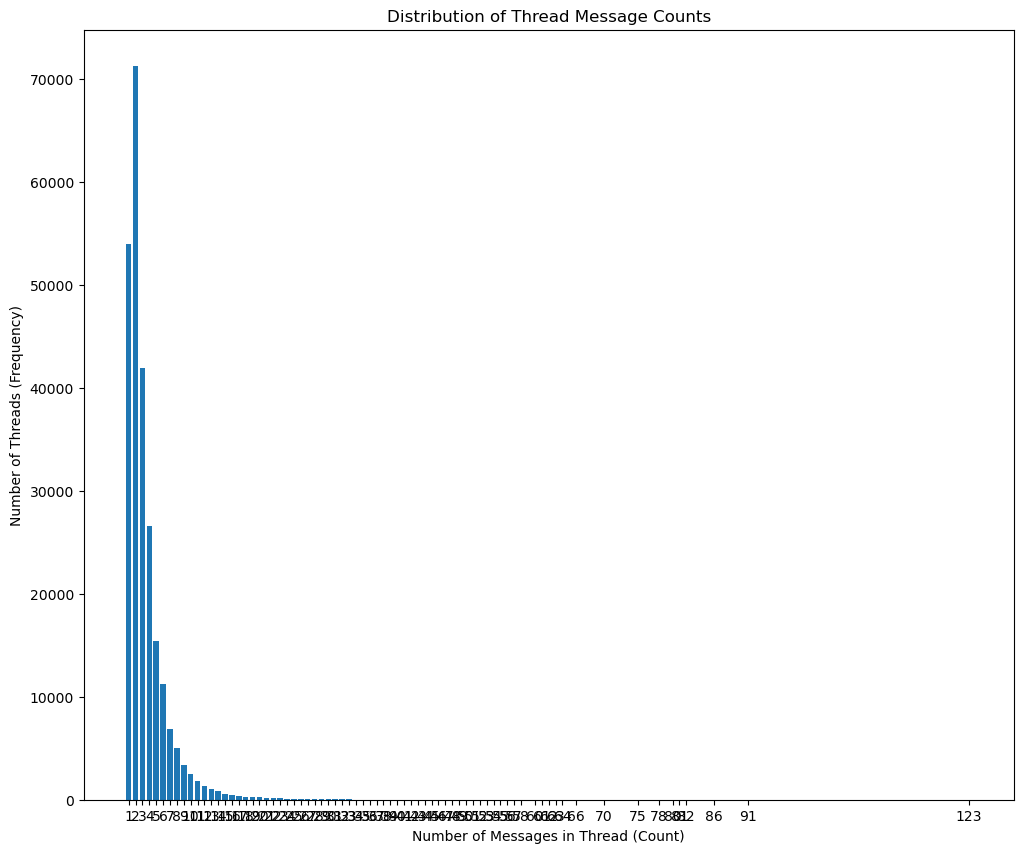

the number of threads is 246588
the number of messages is 848790
 the average number of messages per thread is 3.4421383035670834


In [ ]:
# Get the count of each Thread ID
thread_counts = data_sample['Thread ID'].value_counts()
# Now, get the frequency of each count (i.e., how many threads have count=1, count=2, etc.)
count_frequency = thread_counts.value_counts().sort_index()

# Plot
plt.figure(figsize=(12,10))
plt.bar(count_frequency.index, count_frequency.values)
plt.xlabel('Number of Messages in Thread (Count)')
plt.ylabel('Number of Threads (Frequency)')
plt.title('Distribution of Thread Message Counts')
plt.xticks(count_frequency.index)  # Show all counts on x-axis if not too many
plt.show()
print(f"the number of threads is {len(thread_counts)}")
print(f"the number of messages is {thread_counts.sum()}")
print(f" the average number of messages per thread is {thread_counts.mean()}")


In [11]:
# Create embeddings for all texts
texts = question_answer_pairs["chunk_text"].tolist()
thread_ids = question_answer_pairs["_id"].tolist()
actual_responses = question_answer_pairs["Actual Response Sent to Patient"].tolist()
embeddings = embeddings_model.embed_documents(texts)


print("------------------finished embedding---------------")
# Initialize Pinecone index if not exists
index_name = "question-answer-pairs"
if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=len(embeddings[0]),
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )

# Get the index
index = pc.Index(index_name)

# Process in batches of 100
batch_size = 100
for i in range(0, len(texts), batch_size):
    # Get the current batch
    batch_end = min(i + batch_size, len(texts))
    batch_vectors = []
    
    # Prepare vectors for the current batch
    for j in range(i, batch_end):
        batch_vectors.append({
            "id": str(thread_ids[j]),
            "values": embeddings[j],
            "metadata": {
                "text": texts[j],
                "thread_id": str(thread_ids[j]),
                "response": actual_responses[j],  # Added the actual response
                "model": "sentence-transformers/all-mpnet-base-v2"
            }
        })
    
    # Upsert the batch
    index.upsert(vectors=batch_vectors, namespace="subsample-space")
    print(f"Processed batch {i//batch_size + 1}, vectors {i} to {batch_end}")

print(f"Successfully saved all {len(texts)} embeddings to Pinecone using Thread IDs as identifiers")

------------------finished embedding---------------
Processed batch 1, vectors 0 to 100
Processed batch 2, vectors 100 to 200
Processed batch 3, vectors 200 to 300
Processed batch 4, vectors 300 to 400
Processed batch 5, vectors 400 to 500
Processed batch 6, vectors 500 to 600
Processed batch 7, vectors 600 to 700
Processed batch 8, vectors 700 to 800
Processed batch 9, vectors 800 to 900
Processed batch 10, vectors 900 to 1000
Processed batch 11, vectors 1000 to 1100
Processed batch 12, vectors 1100 to 1200
Processed batch 13, vectors 1200 to 1300
Processed batch 14, vectors 1300 to 1400
Processed batch 15, vectors 1400 to 1500
Processed batch 16, vectors 1500 to 1600
Processed batch 17, vectors 1600 to 1700
Processed batch 18, vectors 1700 to 1800
Processed batch 19, vectors 1800 to 1900
Processed batch 20, vectors 1900 to 2000
Processed batch 21, vectors 2000 to 2100
Processed batch 22, vectors 2100 to 2200
Processed batch 23, vectors 2200 to 2300
Processed batch 24, vectors 2300 to

In [31]:
vector = embeddings_model.embed_query("No side effects noted so far. It's been easy to tolerate this drug while Ozempic")
response = index.query(
    namespace="subsample-space",
    vector=vector,
    top_k=10,
    include_values=False,
    include_metadata=True
)
    
print(response)

{'matches': [{'id': '254764934',
              'metadata': {'model': 'sentence-transformers/all-mpnet-base-v2',
                           'response': 'The refill has been sent for Trulicity '
                                       '1.5 mg per week <13><10>Let me know '
                                       "how you feel in 3 months and we'll "
                                       'check your labs again at that '
                                       'point.<13><10><13><10>Katy Young-Lee '
                                       'M.D.<13><10>',
                           'text': "No side effects noted so far. It's been "
                                   'easy to tolerate this drug while Ozempic '
                                   'just destroyed me.I had all kinds of side '
                                   'effects with that one, but Trulicity has '
                                   'been just fine. Thx. ',
                           'thread_id': '254764934'},
              's

# evaluation:
focus on one provider's response to see the similarity among patients
closest response from the same provider 

In [13]:
# index_name = "quickstart-py"
# if not pc.has_index(index_name):
#     pc.create_index_for_model(
#         name=index_name,
#         cloud="aws",
#         region="us-east-1",
#         embed={
#             "model":"llama-text-embed-v2",
#             "field_map":{"text": "chunk_text"}
#         }
#     )
# # Target the index
# dense_index = pc.Index(index_name)

# # Upsert the records in batches
# BATCH_SIZE = 96
# for i in range(0, len(records), BATCH_SIZE):
#     batch = records[i:i + BATCH_SIZE]
#     dense_index.upsert_records("example-namespace", batch)
#     # Small delay between batches
#     time.sleep(1)

# # Wait for the upserted vectors to be indexed
# import time
# time.sleep(10)
# # View stats for the index
# stats = dense_index.describe_index_stats()
# print(stats)
# # Search the dense index and rerank results
# query = "Chiang"
# reranked_results = dense_index.search(
#     namespace="example-namespace",
#     query={
#         "top_k": 10,
#         "inputs": {
#             'text': query
#         }
#     },
#     rerank={
#         "model": "bge-reranker-v2-m3",
#         "top_n": 10,
#         "rank_fields": ["chunk_text"]
#     }   
# )

# # Print the reranked results
# for hit in reranked_results['result']['hits']:
#     print(f"id: {hit['_id']}, score: {round(hit['_score'], 2)}, text: {hit['fields']['chunk_text']}, Actual Response Sent to Patient: {hit['fields']['Actual Response Sent to Patient']}")